**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import copy

import data_loading_code as dlc

Load data

In [2]:
# get data, pre-process
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = dlc.preprocess_pandas(data, columns)                             # pre-process

# split the data into training, validation, and test splits
# first get 50% for training
X_train, X_rest, y_train, y_rest = train_test_split(
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.5,
    random_state=0,
    shuffle=True
)

# split rest to get 50/20/30 split
X_val, X_test, y_val, y_test = train_test_split(
    X_rest,
    y_rest,
    test_size=0.6,  # 60% of 50% = 30% test
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
X_train_vec = word_vectorizer.fit_transform(X_train).todense() # transform texts to sparse matrix and then to dense matrix for Pytorch
X_val_vec = word_vectorizer.transform(X_val).todense()
X_test_vec = word_vectorizer.transform(X_test).todense()

# convert to tensors
train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor)

val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor)
val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor)

test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor)

# build datasets and DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Simple ANN

In [3]:
# class ANNClassifier(nn.Module):
#     def __init__(self, input_size):
#         super(ANNClassifier, self).__init__()

#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(input_size, 16)
#         self.bn1 = nn.BatchNorm1d(16)
#         self.relu1 = nn.LeakyReLU(negative_slope=0.01)

#         self.fc2 = nn.Linear(16, 8)
#         self.bn2 = nn.BatchNorm1d(8)
#         self.relu2 = nn.LeakyReLU(negative_slope=0.01)
#         self.drop1 = nn.Dropout(0.7)

#         self.fc3 = nn.Linear(8, 1)  # Single neuron output

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.relu1(self.bn1(self.fc1(x)))
#         x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
#         x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
#         return x

In [4]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(val_loader, model, criterion)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, 'amazonclass.pth')

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [6]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [7]:
input_size = train_x_tensor.shape[1]
model = ANNClassifier(input_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=500)

Epoch 1/500, Train Loss: 0.7369, Val Loss: 0.6887, Train Acc: 52.20%, Val Acc: 53.00%
Epoch 2/500, Train Loss: 0.6865, Val Loss: 0.6866, Train Acc: 54.20%, Val Acc: 53.00%
Epoch 3/500, Train Loss: 0.6072, Val Loss: 0.6798, Train Acc: 60.20%, Val Acc: 57.00%
Epoch 4/500, Train Loss: 0.5753, Val Loss: 0.6642, Train Acc: 63.20%, Val Acc: 64.50%
Epoch 5/500, Train Loss: 0.5607, Val Loss: 0.6388, Train Acc: 68.60%, Val Acc: 68.50%
Epoch 6/500, Train Loss: 0.5299, Val Loss: 0.6212, Train Acc: 69.00%, Val Acc: 71.00%
Epoch 7/500, Train Loss: 0.5013, Val Loss: 0.6114, Train Acc: 71.00%, Val Acc: 73.50%
Epoch 8/500, Train Loss: 0.5024, Val Loss: 0.6041, Train Acc: 68.00%, Val Acc: 74.00%
Epoch 9/500, Train Loss: 0.4538, Val Loss: 0.5957, Train Acc: 76.40%, Val Acc: 74.50%
Epoch 10/500, Train Loss: 0.4610, Val Loss: 0.5877, Train Acc: 75.20%, Val Acc: 73.50%
Epoch 11/500, Train Loss: 0.4502, Val Loss: 0.5813, Train Acc: 74.60%, Val Acc: 75.00%
Epoch 12/500, Train Loss: 0.4422, Val Loss: 0.5772, 

Accuracy on testing dataset: 81.5%
Confusion Matrix:
 [[90 16]
 [21 73]]


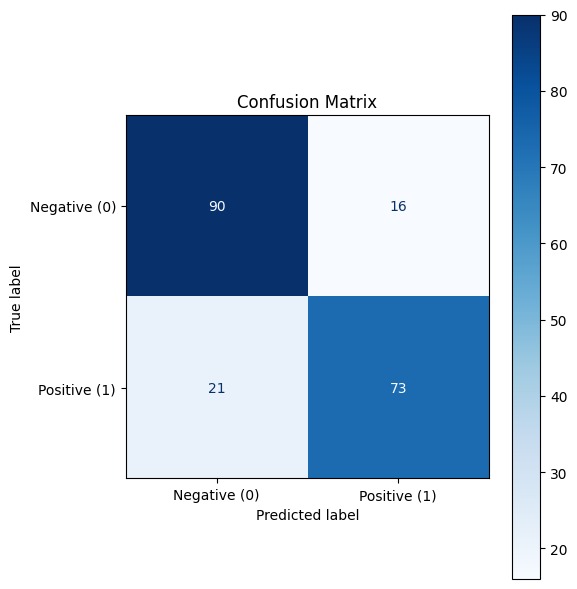

In [8]:
# Load best model
model = ANNClassifier(input_size)
model.load_state_dict(torch.load('amazonclass.pth'))

# Evaluate best model
_, test_acc, labels, preds = test_model(loader=val_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
plot_confusion_matrix(labels, preds)